In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp given_models

# given_models
> i.e. routines for setting up and using pretrained AutoEncoder models

Currently included:
- Baselines: Spectrogram (i.e. complex STFT), MagSpectrogram, MagDPhaseSpectrogram, MelSpectrogram
- Diffusion models: DVAE (unmasked)
- VAEs: RAVE

To be added: 
- Diffusion models: masked DVAE , archinet's
- Others groups': JukeBox (as "IceBox")

In [1]:
#|hide
from nbdev.showdoc import *

In [2]:
#|export
from __future__ import annotations  # for type hints LAION code samples
import os
from pathlib import Path
import numpy as np 
import torch
import torch.nn as nn
import torchaudio
from torchaudio import transforms as T
import pytorch_lightning as pl
import math
import subprocess
from copy import deepcopy
import pytorch_lightning as pl
from einops import rearrange

try:
    import rave
    import gin
    got_rave = True
except:
    print("  given_models: Warning: RAVE import failed")
    got_rave = False

import laion_clap 
from laion_clap.training.data import get_audio_features

from aeiou.core import batch_it_crazy
from aeiou.hpc import freeze
from autoencoders.models import AudioAutoencoder

try:
    from audio_algebra.DiffusionDVAE import DiffusionDVAE
    from audio_algebra.DiffusionDVAE import sample as dvae_sample
    got_dvae = True
except:
    print("  given_models: Warning: DVAE import failed")
    got_dvae = False

# StackedDiffAE
#if False:  # incompatibility with StackedAE*Cond? 
#    from audio_algebra.StackedDiffAE import LatentAudioDiffusionAutoencoder 
#    from audio_algebra.StackedDiffAE import sample as stacked_sample
#    from autoencoders.models import AudioAutoencoder # audio-diffusion
    
    
from audio_algebra.StackedAELatentDiffusionCond import LatentAudioDiffusionAutoencoder, StackedAELatentDiffusionCond
from audio_algebra.StackedAELatentDiffusionCond import sample as ldc_sample
from audio_algebra.StackedAELatentDiffusionCond import resample as ldc_resample

In [3]:
#|hide
# imports not needed for library itself, but used in notebook documentation/tests/demo
import matplotlib.pyplot as plt
from aeiou.viz import playable_spectrogram, audio_spectrogram_image, tokens_spectrogram_image, show_point_cloud
from aeiou.core import load_audio, get_device
from aeiou.datasets import Stereo
from IPython.display import display, HTML, Audio  # just for displaying inside notebooks

# Wrapper API: "GivenModelClass"
We're going to make a bunch of wrappers that are PyTorch modules. The API for the wrappers will be as follows: 
- `.encode()`: encodes the (batch of) (raw) audio waveform(s) into encodings aka "representations" `reps`, where `reps` should have shape `([b,]c,d,n)` where `b` is an optional batch dimension (matching that of the waveform input), `c` may or may not correspond to actual audio channels (e.g. for DVAE, c=1 even for stereo). `d` and `n` are typically the "dimensions" of the embeddings and the time step/frame, respectively, but some models may not respect this.
- `.decode()`: decodes the (batch of) encodings/representations from the encoder into "reconstruction" waveforms `recons`
- `.forward()`: calls *both* `encode()` and `decode()` in succesion, returns tuple `(reps, recons)`
- `.setup()`: an optional routine that will load checkpoints & do other 'init' stuff (but not done automatically in `init`)
- `self.ckpt_info{}`: dict that includes URL and approved hash value for pretrained model checkpoint. Default is no info

In [4]:
#|export
class GivenModelClass(nn.Module):
    "This provides an (optional) 'shorthand' structure for (some) given_models"
    def __init__(self,
        zero_pad=True,
        make_sizes_match=True,
        ckpt_info={'ckpt_path':'', 'ckpt_url':'','ckpt_hash':'', 'gdrive_path':''}, # info on pretrained checkpoints
        **kwargs,  # these are so that some models can ignore kwargs needed by others
        ):
        super().__init__()
        self.make_sizes_match, self.orig_shape, self.zero_pad, self.ckpt_info  = make_sizes_match, None, zero_pad, ckpt_info
        self.name = self.__class__.__name__  # just a shorthand
        self.ckpt_dir = os.path.expanduser('~/checkpoints')
        if not os.path.exists(self.ckpt_dir): os.makedirs(self.ckpt_dir)
    def setup(self, gdrive=True):
        "Setup can include things such as downloading checkpoints"
        pass  
    def encode(self, waveform: torch.Tensor, **kwargs) -> torch.Tensor:
        return None
    def decode(self, waveform: torch.Tensor, **kwargs) -> torch.Tensor:
        return None    
    def forward(self, waveform: torch.Tensor)-> (torch.Tensor, torch.Tensor):
        "Calls .encode() and .decode() in succession, returns both results as tuple"
        reps = self.encode(waveform)
        recons = self.decode(reps)
        return (reps, recons)
    
    def get_checkpoint(self, gdrive=True):
        "This just ensures that the checkpoint file (if one is available) will be present on the local disk at self.ckpt_info['ckpt_path']"
        if self.ckpt_info=={} or all(x=='' for x in self.ckpt_info.values()): 
            print("No checkpoint info available.")
            return
        #@title Mount or Download Checkpoint
        on_colab = os.path.exists('/content')
        if on_colab and gdrive:  # on colab, try to mount checkpoint from drive unless user prefers download
            from google.colab import drive
            drive.mount('/content/drive/') 
            ckpt_file = '/content/drive/'+self.ckpt_info['gdrive_path']
            while not os.path.exists(ckpt_file):
                print(f"\nPROBLEM: Expected to find the checkpoint file at {ckpt_file} but it's not there.")
                print(f"Where is it? (Go to the File system in the left sidebar and find it)")
                ckpt_file = input('Enter location of checkpoint file: ')
            self.ckpt_info['ckpt_path']= ckpt_file
        else:
            ckpt_file = os.path.expanduser(self.ckpt_info['ckpt_path']) #'checkpoint.ckpt'
            if not os.path.exists(ckpt_file):
                url = self.ckpt_info['ckpt_url']
                if self.debug: print(f"Can't find checkpoint file {ckpt_file}. Will try to download it from {url}")
                if 'drive.google.com' in url:
                    # downloading large files from GDrive requires special treatment to bypass the dialog button it wants to throw up
                    id = url.split('/')[-2]
                    cmd = f"gdown -O {ckpt_file} {id}"
                else:
                    print(f"Downloading to {ckpt_file}")
                    cmd = f"curl -L {url} -o {ckpt_file}"
                    if self.debug: print("cmd = ",cmd)
                subprocess.run(cmd, shell=True, check=True) 
                if self.ckpt_info['ckpt_hash'] != '': # check the hash if it was given
                    print(f"\nSecurity: checking hash on downloaded checkpoint file...")
                    new_hash = subprocess.run(['shasum', '-a','256',ckpt_file], stdout=subprocess.PIPE).stdout.decode('utf-8').split(' ')[0]
                    #new_hash = subprocess.run(['md5sum',ckpt_file], stdout=subprocess.PIPE).stdout.decode('utf-8')
                    assert new_hash == self.ckpt_info['ckpt_hash'], "Hashes don't match. STOP THE NOTEBOOK. DO NOT EXECUTE."
                    print("Checkpoint hash checks out.")
            else:
                print("Checkpoint found!")
    
    def match_sizes(self, recon) -> torch.Tensor:
        "match recon size to original waveform size, if possible. Need to have set self.orig_shape earlier"
        if self.make_sizes_match and (self.orig_shape is not None) and (recon.shape != self.orig_shape):
            if recon.shape[-1] > self.orig_shape[-1]:  # recon is longer
                recon = recon[...,:self.orig_shape[-1]]
            else: # recon is shorter
                recon2 = torch.zeros(self.orig_shape)  # slow but what are you gonna do
                recon2[...,:self.orig_shape[-1]] = recon
                recon = recon2 
            assert recon.shape == self.orig_shape, f"Did not succeed in making size match. recon.shape ({recon.shape}) != self.orig_shape ({self.orig_shape})"
        return recon       
    
    #--- couple extra routines probably only useful for fourier-based AE's but no harm done including them here
    def next_power_of_2(self, x:int) -> int:  
        return 1 if x == 0 else 2**(x - 1).bit_length()

    def zero_pad_po2(self, x:int) -> int:
        "useful for padding to nearest power of 2, useful for fourier-based transforms"
        new_shape = list(x.shape)
        new_shape[-1] = self.next_power_of_2(new_shape[-1])
        new_x = torch.zeros(new_shape).to(x.device)
        new_x[...,:x.shape[-1]] = x
        return new_x
  

# Baselines: STFT "AutoEncoders"

In [5]:
#|export
class SpectrogramAE(GivenModelClass):
    "Raw (complex) spectrogram. See torchaudio.Spectrogram & InverseSpectrogram for kwarg info"
    def __init__(self,
        n_fft=1024,   
        hop_length=256,
        center=True,
        **kwargs,
    ):
        super().__init__()
        self.encoder = T.Spectrogram(power=None, n_fft=n_fft, hop_length=hop_length, center=center, **kwargs)
        self.decoder = T.InverseSpectrogram(    n_fft=n_fft, hop_length=hop_length, center=center, **kwargs)
        
    def encode(self, waveform: torch.Tensor,**kwargs) -> torch.Tensor:
        "Note that this produces complex numbers by default"
        self.orig_shape = waveform.shape # can use this for matching output size later
        return self.encoder(self.zero_pad_po2(waveform)) if self.zero_pad else self.encoder(waveform)

    def decode(self, reps: torch.Tensor, **kwargs) -> torch.Tensor:
        "this decoder offers perfect reconstruction"
        return self.match_sizes( self.decoder(reps) )

Let's test that...

device = cuda
Resampling ../aeiou/examples/example.wav from 44100 Hz to 48000 Hz


waveform.shape = torch.Size([2, 55728])


/fsx/shawley/envs_sm/aa/lib/python3.10/site-packages/torchaudio/transforms/_transforms.py:611: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(
/fsx/shawley/envs_sm/aa/lib/python3.10/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


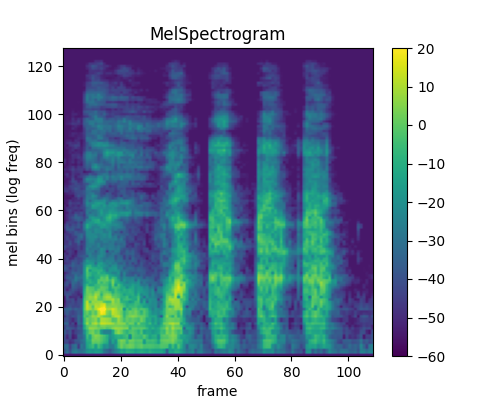

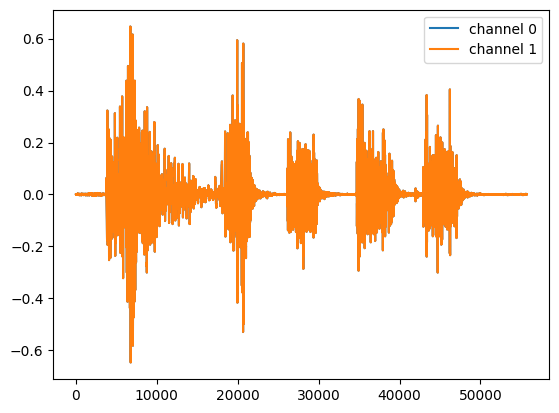

In [6]:
#| eval: false
device = get_device()
print("device =",device)
if torch.device('mps') == device: 
    print("Actually for spectrogram, MPS is going to cause 'TypeError: Trying to convert ComplexFloat to the MPS backend but it does not have support for that dtype', so you'll get cpu")
    device='cpu'

data_path = '../aeiou/examples/'
waveform = load_audio(data_path+'example.wav')
#waveform = load_audio('/admin/home-shawley/jsontest.wav')
stereo_op = Stereo()
waveform = stereo_op(waveform)

def nb_play(waveform):
    display(Audio(waveform, rate=48000))
    print("waveform.shape =",waveform.shape)
    #playable_spectrogram(waveform, output_type='live')
    spec_graph = audio_spectrogram_image(waveform.cpu(), justimage=False, db=False, db_range=[-60,20])
    display(spec_graph)
    for c in range(waveform.shape[0]):
        plt.plot(waveform[c].cpu().numpy(), label=f'channel {c}')
    plt.legend()
    plt.show()
    
nb_play(waveform) 

Now show that "`recon`" results of the inverse transform are very close to the original waveform:

spec.shape, recon.shape =  torch.Size([2, 513, 257]) torch.Size([2, 55728])
spec.dtype =  torch.complex64


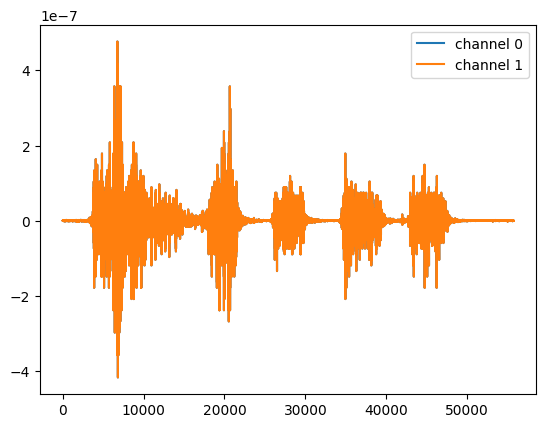

In [7]:
#| eval: false
given_model = SpectrogramAE().to(device)
spec, recon = given_model.forward(waveform.to(device))
print("spec.shape, recon.shape = ",spec.shape, recon.shape)
print("spec.dtype = ",spec.dtype)
diff = recon.cpu()-waveform

#playable_spectrogram(diff, output_type='live') #plot/play the difference
#spec_graph = audio_spectrogram_image(diff, justimage=False, db=False, db_range=[-60,20])
#display(spec_graph)
for c in range(waveform.shape[0]):
    plt.plot(diff[c].cpu().numpy(), label=f'channel {c}')
plt.legend()

In [8]:
#|export
class MagSpectrogramAE(GivenModelClass):
    "Magnitude spectrogram encoder, GriffinLim decoder"
    def __init__(self,
        n_fft=1024,   
        hop_length=256,
        center=True,
        **kwargs,
    ):
        super().__init__()
        self.encoder = T.Spectrogram(power=2, n_fft=n_fft, hop_length=hop_length, center=center, **kwargs)
        self.decoder = T.GriffinLim(          n_fft=n_fft, hop_length=hop_length, **kwargs)
        
    def encode(self, waveform: torch.Tensor, **kwargs) -> torch.Tensor:
        self.orig_shape = waveform.shape
        return self.encoder(self.zero_pad_po2(waveform)) if self.zero_pad else self.encoder(waveform)

    def decode(self, reps: torch.Tensor, **kwargs) -> torch.Tensor:
        "Note that GriffinLim decoding *guesses* at the phase"
        return self.match_sizes( self.decoder(reps) )

In [9]:
#| eval: false

# test that
magspecfunc = MagSpectrogramAE().to(device)
magspec, recon2 = magspecfunc.forward(waveform.to(device))
print("magspec.shape, recon2.shape = ",magspec.shape, recon2.shape )
print("magspec.dtype = ",magspec.dtype)
recon2 = recon2.to('cpu')
diff = recon2-waveform

#playable_spectrogram(recon2, output_type='live') #plot/play the difference

magspec.shape, recon2.shape =  torch.Size([2, 513, 257]) torch.Size([2, 55728])
magspec.dtype =  torch.float32


In [ ]:
#|export
class MagDPhaseSpectrogramAE(GivenModelClass):
    "Magnitude + PhaseChange spectrogram encoder, Exact decoder"
    def __init__(self,
        n_fft=1024,   
        hop_length=256,
        center=True,   # used for fft argument
        init='true',   # initial angle in decoder:'true'|'rand'|'zero'
        use_cos=False, # use vector cosine rule to get angle
        debug=False,
        cheat=False,   # store original signal for comparison later
        **kwargs,
    ):
        super().__init__()
        self.encoder = T.Spectrogram(power=None, n_fft=n_fft, hop_length=hop_length, center=center, **kwargs)
        self.decoder = T.InverseSpectrogram(    n_fft=n_fft, hop_length=hop_length, center=center, **kwargs)
        #self.gl = T.GriffinLim(          n_fft=n_fft, hop_length=hop_length, **kwargs)
        self.use_cos, self.cheat, self.debug, self.init = use_cos, cheat, debug, init
        self.pi = 3.141592653589
        
    def encode(self, waveform: torch.Tensor, **kwargs) -> torch.Tensor:
        self.orig_shape = waveform.shape
        spec =  self.encoder(self.zero_pad_po2(waveform)) if self.zero_pad else self.encoder1(waveform)
        mag, theta = torch.abs(spec), torch.angle(spec)
        if self.debug: theta = torch.where(theta < 0, theta+2*self.pi, theta) # just to make it easier to compare later
        if self.cheat: 
            self.spec_orig, self.mag_orig, self.theta = spec, mag, theta
        if self.use_cos:  # doesn't sound as good imho
            x, y = torch.real(spec), torch.imag(spec)
            mag_tm1 = torch.roll(mag, 1, -1)  # previus timestep rolled forward for subtraction/multiplication
            x_tm1, y_tm1 = torch.roll(x, 1, -1), torch.roll(y, 1, -1)
            numerator, denominator = (x*x_tm1 + y*y_tm1), (mag*mag_tm1)
            acos_arg = torch.where( denominator==0, 1, numerator/denominator) # aviod nans, div by 0
            acos_arg =  torch.clip( acos_arg , -1, 1) # another bounds check
            dtheta = torch.acos(acos_arg)  # could perhaps approximate acos by sqrt(2*(1-cos_arg)) when cos_arg is near 1
        else:  # this is faster and sounds better too. 
            theta_tm1 = torch.roll(theta, 1, -1)
            dtheta = theta-theta_tm1 # this can give bad vals when theta1/2 are on opposite sides of x=0 line
            dtheta = torch.where(dtheta < 0, dtheta+2*self.pi, dtheta)  # force phase to be non-decreasing
        dtheta[:,:,0] = theta[:,:,0]  # encode initial value of theta at first position, helps it sound better
        return torch.concatenate((mag,dtheta))  #package mags together, dthetas together
        
        
    def decode(self, reps: torch.Tensor, **kwargs) -> torch.Tensor:
        "Note that GriffinLim decoding *guesses* at the phase"
        nc = reps.shape[-3] // 2 # number of audio channels
        mag, dtheta = reps[0:nc,:,:], reps[nc:,:,:] # split the packaging
        #return self.gl(mag**2)  # griffin lim cop-out
        if self.cheat:
            theta = self.theta.clone() # cheating
        else:
            theta = torch.zeros(dtheta.shape).to(reps.device)
            if self.init=='true':
                theta[:,:,0] = dtheta[:,:,0]  # initial value of theta, helps it sound better vs. random or zeros
            elif self.init=='rand':
                theta[:,:,0] = torch.rand(dtheta.shape[:-1])
            for t in range(1,reps.shape[-1]):  # integrate theta along the time (last) dimension
                theta[:,:,t] = theta[:,:,t-1] + dtheta[:,:,t]
                theta[:,:,t] = torch.where( theta[:,:,t] < 2*self.pi, theta[:,:,t], theta[:,:,t] - 2*self.pi)            
        spec = mag* ( torch.cos(theta) + 1j*torch.sin(theta) )
        if self.debug:
            self.mag_new, self.theta_new = torch.abs(spec), theta
            self.spec_new = spec
        return self.match_sizes( self.decoder(spec) )

In [ ]:
#| eval: false  
magdphasefunc = MagDPhaseSpectrogramAE(debug=True, init='true').to(device)
magdtheta, recon3 = magdphasefunc.forward(waveform.to(device))
recon3 = recon3.cpu()
#playable_spectrogram(recon3, output_type='live') #plot/play the difference

In [ ]:
#| eval: false
diff = recon3 - waveform
spec_graph = audio_spectrogram_image(recon3, justimage=False, db=False, db_range=[-60,20])
display(spec_graph)
for c in range(1): 
    print(f"Channel {c}:")
    for thing, name in zip([waveform, recon3, diff], ['waveform', 'recon', 'diff']):
        plt.plot(thing[c].cpu().numpy(), alpha=0.5, label=name)
    plt.legend()
    plt.show()

In [ ]:
#|export
class MelSpectrogramAE(GivenModelClass):
    "Mel spectrogram encoder, GriffinLim decoder"
    def __init__(self,
        sample_rate=48000,
        n_fft=1024,   
        hop_length=256,
        center=True,
        **kwargs, # these are mainly just so that we can ignore kwargs that other models need
    ):
        super().__init__()
        self.encoder = nn.Sequential( T.MelSpectrogram(sample_rate=sample_rate, n_fft=n_fft, hop_length=hop_length, center=center, **kwargs))
        self.inv_melscale_t = T.InverseMelScale(n_stft=n_fft // 2 + 1)
        self.decoder = T.GriffinLim(n_fft=n_fft, hop_length=hop_length, **kwargs)
        
    def encode(self, waveform: torch.Tensor, **kwargs) -> torch.Tensor:
        self.orig_shape = waveform.shape
        return self.encoder(self.zero_pad_po2(waveform)) if self.zero_pad else self.encoder(waveform)

    def decode(self, melspec: torch.Tensor, **kwargs) -> torch.Tensor:
        spec = self.inv_melscale_t(melspec)
        return self.match_sizes( self.decoder(spec) )
    
    def forward(self, waveform: torch.Tensor)-> (torch.Tensor, torch.Tensor):
        "Calls .encode() and .decode() in succession, returns both results as tuple"
        reps = self.encode(waveform)
        recons = self.decode(reps)
        return (reps, recons)

In [ ]:
#| eval: false

# test that
i_love_slow_code = False
if i_love_slow_code: 
    melspecfunc = MelSpectrogramAE().to(device)
    melspec, recon4 = melspecfunc.forward(waveform.to(device))
    print("melspec.device, melspec.shape, recon4.shape = ",melspec.device, melspec.shape, recon4.shape )
    print("melspec.dtype =",melspec.dtype)
    recon4 = recon4.to('cpu')
    #display(playable_spectrogram(recon4, output_type='live'))

In [ ]:
#| eval: false
if i_love_slow_code: 
    diff = recon4-waveform
    #display(playable_spectrogram(diff, specs="waveform", output_type='live')) #plot/play the difference
    spec_graph = audio_spectrogram_image(recon4, justimage=False, db=False, db_range=[-60,20])
    display(spec_graph)
    c = 0
    for thing, name in zip([waveform, recon4, diff],["waveform", "recon", "diff"]):
        plt.plot(thing[c].cpu().numpy(), alpha=0.5, label=name)
    plt.legend()
    plt.show()

# Diffusion AutoEncoders

## 'DVAE' (old model) 
Wrapper for Zach's DVAE/diffAE model from September/October. This cannot be subclassed from the above `GivenModel` class if we want to be able to import the checkpoint files. 

In [ ]:
#|export
class DVAEWrapper(GivenModelClass):
    "Wrapper for (hawley's fork of) Zach's DiffusionDVAE"
    def __init__(self, 
        args_dict = {'num_quantizers':0, 'sample_size': 65536, 'demo_steps':50, 'sample_rate':48000, 'latent_dim': 64, 'pqmf_bands':1, 'ema_decay':0.995, 'num_quantizers':0},
        debug=True,
        **kwargs,
    ):
        super().__init__()
        if not got_dvae: return
        class DictObj:
            def __init__(self, in_dict:dict):
                for key, val in in_dict.items():
                    if isinstance(val, (list, tuple)):
                        setattr(self, key, [DictObj(x) if isinstance(x, dict) else x for x in val])
                    else:
                        setattr(self, key, DictObj(val) if isinstance(val, dict) else val)
        self.global_args = DictObj(args_dict)
        self.model = DiffusionDVAE(self.global_args)
        self.noise = None 
        self.demo_steps = self.global_args.demo_steps
        self.demo_samples = self.global_args.sample_size 
        self.debug = debug
        self.ckpt_info={'ckpt_url':'https://drive.google.com/file/d/1C3NMdQlmOcArGt1KL7pH32KtXVCOfXKr/view?usp=sharing',
                        'ckpt_hash':'6a304c3e89ea3f7ca023f4c9accc5df8de0504595db41961cc7e8b0d07876ef5',
                        'gdrive_path':'MyDrive/AI/checkpoints/DiffusionDVAE.ckpt',
                        'ckpt_path':'~/checkpoints/dvae_checkpoint.ckpt'}
    
    def encode_it(self, demo_reals):
        module = self.model
        encoder_input = demo_reals

        if module.pqmf_bands > 1:
            encoder_input = module.pqmf(demo_reals).to(demo_reals.device)

        noise = torch.randn([demo_reals.shape[0], 2, self.demo_samples]).to(encoder_input.device)

        with torch.no_grad():
            embeddings = module.encoder_ema(encoder_input)
            if module.quantized:
                if debug: print("Hey, did you know you're quantized? ")
                #Rearrange for Memcodes
                embeddings = rearrange(embeddings, 'b d n -> b n d')
                embeddings, _= module.quantizer_ema(embeddings)
                embeddings = rearrange(embeddings, 'b n d -> b d n')
        
        embeddings = torch.tanh(embeddings)
        return embeddings, noise
        
    def encode(self, waveform: torch.Tensor) -> torch.Tensor:
        self.orig_shape = waveform.shape
        self.demo_samples = waveform.shape[-1]
        reps, self.noise = self.model.encode_it(waveform)
        return reps

    def decode(self, reps: torch.Tensor, demo_steps=None) -> torch.Tensor:
        #print("reps.shape, self.noise.shape = ",reps.shape, self.noise.shape)
        if demo_steps is None: demo_steps=self.demo_steps
        fake_batches = dvae_sample(self.model.diffusion_ema, self.noise, demo_steps, 0, reps)
        recon = rearrange(fake_batches, 'b d n -> d (b n)') # Put the demos together
        return recon
    
    def setup(self, gdrive=True):  
        ckpt_file = self.ckpt_info['ckpt_path']
        print(f"DVAE: attempting to load checkpoint {ckpt_file}")
        self.get_checkpoint(gdrive=gdrive)
        try:
            self.model = self.model.load_from_checkpoint(ckpt_file, global_args=self.global_args)
        except Exception as e:
            print(f"Sorry, exception = {e}. Going with random weights")
        self.model.encode_it = self.encode_it
        self.model.quantized = self.global_args.num_quantizers > 0 
        self.model.eval() # disable randomness, dropout, etc...
        freeze(self.model)  # freeze the weights for inference

## Stacked DiffAE

In [ ]:
#|export 
class StackedDiffAEWrapper(GivenModelClass):
    "Wrapper for (hawley's fork of) Zach's Stacked Latent DiffAE model"
    def __init__(self, 
        debug=True,
        first_stage_config=None,
        ckpt_info=None,
        **kwargs,
    ):
        super().__init__()
        self.debug = debug

        self.first_stage_config = first_stage_config if first_stage_config is not None else \
            {"capacity": 64, "c_mults": [2, 4, 8, 16, 32], "strides": [2, 2, 2, 2, 2], "latent_dim": 32}
        self.first_stage_autoencoder = AudioAutoencoder( **self.first_stage_config ).requires_grad_(False)
        self.model = LatentAudioDiffusionAutoencoder(autoencoder=self.first_stage_autoencoder)
        self.latent_dim = self.model.latent_dim 
        self.latent_downsampling_ratio = self.model.latent_downsampling_ratio
        
        self.ckpt_info = ckpt_info if ckpt_info is not None else \
            {'ckpt_path':'~/checkpoints/stacked-diffae-more-310k.ckpt',
            'ckpt_hash':'91f33839ecb6e3c41b1e89e1a9e0de0dac2ebe1795efa034797429c202600a58', # old PyL version btw
            'ckpt_url':'', 'gdrive_path':''}
        
    def encode(self, reals: torch.Tensor) -> torch.Tensor:
        return self.model.encode(reals) # returns a (coarsest) single stage of reps
    
    def decode(self, reps: torch.Tensor, steps=100) -> torch.Tensor:
        "goes all the way from small embeddings (latents) to larger embeddings to audio waveform output"
        return self.model.decode(reps, steps=steps) 
 
    # hawley added the following two functions to 'get inside'
    def decode_stage1to2(self, small_reps:torch.Tensor, steps=100)-> torch.Tensor:
        "takes output of encode (small embeddings) and produces next stage (large) embeddings"
        latents = small_reps 
        first_stage_latent_noise = torch.randn([latents.shape[0], self.latent_dim, latents.shape[2]*self.latent_downsampling_ratio]).to(small_reps.device)
        first_stage_sampled = stacked_sample(self.model.diffusion, first_stage_latent_noise, steps, 0, cond=latents)
        large_reps = first_stage_sampled
        return large_reps
 
    def decode_stage2(self, first_stage_sampled, steps=100) -> torch.Tensor: 
        "goes from larger reps to audio output "
        return self.model.autoencoder.decode(first_stage_sampled)

    def setup(self, gdrive=True):  
        ckpt_file = self.ckpt_info['ckpt_path']
        print(f"{self.__class__.__name__}: attempting to load checkpoint {ckpt_file}")
        self.get_checkpoint(gdrive=gdrive)
        try:
            self.model = LatentAudioDiffusionAutoencoder.load_from_checkpoint(self.ckpt_info['ckpt_path'], 
                            autoencoder=self.first_stage_autoencoder, strict=True).requires_grad_(False)
        except Exception as e:
            print(f"Sorry, exception = {e}. Going with random weights")
            
        self.model.diffusion = self.model.diffusion_ema
        self.model.latent_encoder = self.model.latent_encoder_ema
        del self.model.diffusion_ema
        del self.model.latent_encoder_ema
        #self.model.encode_it = self.encode_it
        #self.model.quantized = self.global_args.num_quantizers > 0 
        self.model.eval() # disable randomness, dropout, etc...
        freeze(self.model)  # freeze the weights for inference
        print(f"{self.__class__.__name__}: Setup completed.")

In [ ]:
#| eval: false
# quick check
device=get_device()
sdae_model = StackedDiffAEWrapper()
sdae_model.setup()
sdae_model = sdae_model.to(device)

In [ ]:
#| eval: false
print("waveform.shape =      ",waveform.shape)

waveform_pad = given_model.zero_pad_po2(waveform)
print("waveform_pad.shape =  ",waveform_pad.shape)

# optional: to batch or not to batch?
waveform_batch = waveform_pad.unsqueeze(0)
print(f"waveform_batch.shape = {waveform_batch.shape}, dtype = {waveform.dtype}")


In [ ]:
#| eval: false
reps = sdae_model.encode(waveform_batch.to(device))
print(reps.shape)
print(torch.min(reps), torch.max(reps))

In [ ]:
#| eval: false
recon = sdae_model.decode(reps)
print(recon.shape)
reps2 = sdae_model.decode_stage1to2(reps)
print(reps2.shape)

In [ ]:
#| eval:false
recon2 = sdae_model.decode_stage2(reps2)
print(recon2.shape)
recon = recon.squeeze(0)
print(recon.shape)

In [ ]:
#| eval: false
display(Audio(recon.cpu(), rate=48000))
diff = waveform_pad - recon.cpu()
for thing,name in zip([waveform, recon.cpu(), diff], ['input','recon','diff']):
    plt.plot(thing[0,:].numpy(), alpha=0.5, label=name) # just left channel for now
plt.legend()
plt.show()

## @zaptrem's 1D diffusion unet

Note that several of the routines imported require zaptrem's special fork of Flavio Schneider's repo(s): 
```bash
pip install -U git+https://github.com/Sonauto/audio-diffusion-pytorch.git git+https://github.com/Sonauto/audio-encoders-pytorch.git https://github.com/Sonauto/a-unet/archive/tiled-attention.zip pyloudnorm
```

In [ ]:
#|export

"""
# this is incompatible with the version of audio_diffusion_pytorch we need for Zach's utilities
from audio_diffusion_pytorch.components import (
    UNetV0,
    LTPlugin,
)
from audio_diffusion_pytorch.models import DiffusionAE
import pyloudnorm as pyln
from torch import nn
from audio_encoders_pytorch import TanhBottleneck, MelE1d
"""

In [ ]:
#|export
class DMAE1d(GivenModelClass):
    def __init__(self, debug=False):
        super().__init__()
        self.debug = debug
        self.ckpt_info={'ckpt_url':'https://drive.google.com/file/d/1KKwPbM_Qmu5QvpAs3DdRaYlkaRTG-WJv/view?usp=share_link',
                        'ckpt_path':'~/checkpoints/dmae1d_checkpoint.ckpt',
                        'ckpt_hash':'a11a9c68e5962830b142202e25b3080f553a3a73cd944225b3c7d21fe8c631e9'}
        self.resample_encode = T.Resample(48000, 44100)
        self.resample_decode = T.Resample(44100, 48000)

        UNet = LTPlugin(
            UNetV0,
            num_filters=128,
            window_length=128,
            stride=64,
        )

        self.model = DiffusionAE(
            net_t=UNet,
            dim=1, 
            in_channels=2,
            channels=[256, 512, 512, 512, 1024, 1024, 1024],
            factors=[1, 2, 2, 2, 2, 2, 2],
            linear_attentions=[0, 1, 1, 1, 1, 1, 1],
            attention_features=64,
            attention_heads=8,
            items=[1, 2, 2, 2, 2, 2, 2],
            encoder=MelE1d(
                in_channels=2,
                channels=512,
                multipliers=[1, 1, 1],
                factors=[2, 2],
                num_blocks=[4, 8],
                mel_channels=80,
                mel_sample_rate=44100,
                mel_normalize_log=True,
                out_channels=32,
                bottleneck=TanhBottleneck()
            ),
            inject_depth=4
        )

    def forward(self, waveform_in, *args, **kwargs):
        self.orig_shape = waveform_in.shape
        waveform = self.zero_pad_po2(self.resample_encode(waveform_in))
        waveform_out = self.model(waveform, *args, **kwargs)
        return self.match_sizes(self.resample_decode(waveform_out))

    def encode(self, waveform_in, *args, **kwargs):
        self.orig_shape = waveform_in.shape
        waveform = self.zero_pad_po2(self.resample_encode(waveform_in))
        return self.model.encode(waveform, *args, **kwargs)
    
    @torch.no_grad()
    def decode(self, *args, **kwargs):
        waveform_out = self.model.decode(*args, num_steps=50, show_progress=True, **kwargs)
        return self.match_sizes(self.resample_decode(waveform_out))
    
    def setup(self, gdrive=True):  
        ckpt_file = os.path.expanduser(self.ckpt_info['ckpt_path'])
        print(f"{self.__class__.__name__}: attempting to load checkpoint {ckpt_file}")
        self.get_checkpoint(gdrive=gdrive)
        try:
            #self.model = self.model.load_from_checkpoint(ckpt_file, global_args=self.global_args)
            ae_checkpoint = torch.load(ckpt_file, map_location=torch.device('cpu'))
            # Load the model and optimizer state from the checkpoint
            self.load_state_dict(ae_checkpoint["model_state_dict"], strict=True)
        except Exception as e:
            print(f"Sorry, exception = {e}. Going with random weights")
        self.model.eval() # disable randomness, dropout, etc...
        freeze(self.model)  # freeze the weights for inference

## Test our autoencoder options
First prepare a waveform and instantiate the various models

In [ ]:
#| eval: false
print("waveform.shape =      ",waveform.shape)

waveform_pad = given_model.zero_pad_po2(waveform)
print("waveform_pad.shape =  ",waveform_pad.shape)

# optional: to batch or not to batch?
waveform_batch = waveform_pad.unsqueeze(0)
print(f"waveform_batch.shape = {waveform_batch.shape}, dtype = {waveform.dtype}")

given_models = [ StackedDiffAEWrapper(), SpectrogramAE(), MagSpectrogramAE(), MagDPhaseSpectrogramAE(),  DVAEWrapper()]
                #, DMAE1d(),] # having trouble with missing keys in DMAE1d
_ = [x.setup() for x in given_models]

Now run the waveform through the models:

In [ ]:
#| eval: false
for given_model in given_models:
    display(HTML('<hr>'))
    print("given_model.name = ",given_model.name)
    given_model = given_model.to(device)
    reps = given_model.encode(waveform_batch.to(device))
    recon = given_model.decode(reps) 
    recon = recon.squeeze()
    if len(reps.shape) < 4: reps = reps.unsqueeze(0) # for viz purposes
    print(f"For model {given_model.name}, reps.shape = {reps.shape} and dtype = {reps.dtype}. recon.shape = {recon.shape}")
    if given_model.name in ['DVAEWrapper', 'DMAE1d', 'StackedDiffAEWrapper']:
        title, cmap = 'Embeddings', 'coolwarm'
        vals = reps[:,0,:,:]
    else:
        title, cmap =f'{given_model.name}: 10Log10(abs(Embeddings)**2)', 'viridis'
        vals = 10*torch.log10(torch.abs(reps[:,0,:,:])**2+1e-6)

    #print("vals.shape =",vals.shape)
    display(Audio(recon.cpu(), rate=48000))
    display(tokens_spectrogram_image(vals.cpu(), title=title, mark_batches=True, symmetric=False, cmap=cmap))
    #THIS NEXT LINE MAKES notebook filesize huge: 
    #display(playable_spectrogram(recon.cpu(), specs="all", output_type='live'))
    diff = waveform_pad - recon.cpu()
    for thing,name in zip([waveform, recon.cpu(), diff], ['input','recon','diff']):
        plt.plot(thing[0,:].numpy(), alpha=0.5, label=name) # just left channel for now
    plt.legend()
    plt.show()

# Variational AutoEncoders

In [ ]:
#|export
class RAVEWrapper(GivenModelClass):
    "Wrapper for RAVE"
    def __init__(self,
        pretrained_name='',
        checkpoint_file='percussion',
        config_path='./v2.gin',  # this probably gets ignored
        debug=True,
        **kwargs,
    ):
        super().__init__()
        self.config_path = config_path
        if not got_rave: return 
        if Path(checkpoint_file).suffix == '': checkpoint_file +='.ts'
        self.debug = debug
        self.ckpt_info={'ckpt_url':'https://play.forum.ircam.fr/rave-vst-api/get_model',
                        'ckpt_hash':'',
                        'gdrive_path':'',
                        'ckpt_path':f'{self.ckpt_dir}/{checkpoint_file}'}  
        self.ckpt_info['ckpt_url'] += "/"+Path(checkpoint_file).stem
        gin.parse_config_file(self.config_path)
        self.model = rave.RAVE()
        self.model.eval()
   
    def setup(self, gdrive=False):
        "Setup can include things such as downloading checkpoints"
        self.get_checkpoint(gdrive=gdrive)
        extension = Path(self.ckpt_info['ckpt_path']).suffix
        if self.debug: print("extension =",extension)
        if extension == '.ts' or extension=='':
            self.model = torch.jit.load(self.ckpt_info['ckpt_path'])
        elif extension == '.ckpt':
            self.model.load_state_dict(torch.load(self.ckpt_info['ckpt_path'])["state_dict"])
        else:
            print(f"Sorry, we don't know how to load {extension} checkpoint files. Weights will be uninitialized.")

    def encode(self, waveform: torch.Tensor, **kwargs) -> torch.Tensor:
        with torch.no_grad():
            return self.model.encode(waveform)
    def decode(self, reps: torch.Tensor, **kwargs) -> torch.Tensor:
        with torch.no_grad():
            return self.model.decode(reps) 
    
    def forward(self, waveform: torch.Tensor)-> (torch.Tensor, torch.Tensor):
        "Calls .encode() and .decode() in succession, returns both results as tuple"
        reps = self.encode(waveform)
        recons = self.decode(reps)
        return (reps, recons)

In [ ]:
#| eval: false
if got_rave: 
    given_model = RAVEWrapper(debug=True)
    given_model.setup()

    waveform = load_audio(data_path+'stereo_pewpew.mp3')
    x = 1.5*waveform.clone()[0,:].unsqueeze(0).unsqueeze(0)
    print("x.shape = ",x.shape)
    playable_spectrogram(x[0],output_type='live')

In [ ]:
#| eval: false
if got_rave: 
    z = given_model.encode(x)
    print("z.shape =",z.shape)
    tokens_spectrogram_image(z)

In [ ]:
#| eval: false
if got_rave:
    show_point_cloud(z, mode='lines+markers', method='umap')

In [ ]:
#| eval: false
if got_rave:
    y = given_model.decode(z)
    print("y.shape =",y.shape)
    playable_spectrogram(y[0], output_type='live')

# CLAP embeddings & (lossy) decoding via diffusion

In [10]:
#|export
class CLAPDAE(GivenModelClass):
    "the decoder side of this is the 'demo' side of train_stacked_latent_clap_audio_all_wds.py"
    def __init__(self, 
            clap_fusion=True, 
            clap_amodel='HTSAT-base', 
            device='cuda', 
            first_stage_config = {"capacity": 64, "c_mults": [2, 4, 8, 16, 32], "strides": [2, 2, 2, 2, 2], "latent_dim": 32},
            sample_size = 1048576,
            debug=True):
        super().__init__()
        self.device, self.debug  = device, debug
        self.sample_size, self.demo_samples = sample_size, sample_size
        
        self.clap_module = laion_clap.CLAP_Module(enable_fusion=clap_fusion, device=device, amodel=clap_amodel).requires_grad_(False).eval()
        self.embedder, self.encoder = self.clap_module, self.clap_module # synonyms ;-) 
        self.clap_setup = False
        
        self.first_stage_config = first_stage_config
        self.first_stage_autoencoder = AudioAutoencoder( **self.first_stage_config ).eval()  
        
        self.latent_diffae = LatentAudioDiffusionAutoencoder(self.first_stage_autoencoder).eval()
        self.latent_diffae_setup = False
        
        # main model
        self.latent_diffusion_model = StackedAELatentDiffusionCond(latent_ae=self.latent_diffae, clap_module=self.clap_module).eval()
        self.model = self.latent_diffusion_model

    @torch.no_grad()
    def embed(self, x, *args, **kwargs): # for audio embeddings
        """note that CLAP will embed audio of *arbitrary length* to a single 512-dim vector,
           however our decoder is trained to produce a certain length, so we batchify on encoding
        """
        module = self.latent_diffusion_model
        
        if isinstance(x, str):  # get text embeddings
            print(" embed: got text") 
            embeddings = self.clap_module.get_text_embedding([x, ""], use_tensor=True)[:1,:].to(self.device)
        else:                   # get audio embeddings
            demo_reals = x
            if self.debug: print("      demo_reals .shape, dtype =",demo_reals.shape, demo_reals.dtype)
            while len(demo_reals.shape) < 3: 
                demo_reals = demo_reals.unsqueeze(0) # add batch and/or channel dims 
            embeddings = module.embedder.get_audio_embedding_from_data(demo_reals.mean(dim=1).to(module.device), use_tensor=True).to(demo_reals.dtype)
               
        embeddings = embeddings.unsqueeze(1)  # the way my routines like it, so dims will be [1,1,512]    
        return embeddings
    
    def encode(self, demo_reals, *args, **kwargs): # synonym for embed
        return embed(demo_reals, *args, **kwargs)

    
    @torch.no_grad()
    def generate(self, 
               audio_embeddings, # outputs from 'encode'
               cfg_scales=4,  
               demo_steps=150,
               outer_steps=100,
               init_audio_latents=None,
               init_strength=0.4,
               batch_size=1,
               flatten=True,
               **kwargs):
        embeddings = audio_embeddings.to(self.device)
        module = self.latent_diffusion_model
        if isinstance(cfg_scales,  list): cfg_scales = cfg_scales[0] # yea just taking the first one
        cfg_scale = cfg_scales
        print(f"Generating latents, CFG scale {cfg_scale}. init_audio_latents.shape = {None if init_audio_latents is None else init_audio_latents.shape}")
        if init_audio_latents is not None:
            print("   Calling ldc_resample")
            #fake_latents = ldc_resample(self.latent_diffae.diffusion_ema, init_audio_latents, demo_steps, 0, embedding=embeddings, embedding_scale=cfg_scale,  noise_level=(1.0-init_strength))
            fake_latents = ldc_resample(module.diffusion_ema, init_audio_latents, demo_steps, 0, 
                                        embedding=embeddings, embedding_scale=cfg_scale,  noise_level=(1.0-init_strength))

        else:
            print("   Calling ldc_sample")
            latent_noise = torch.randn([batch_size, module.latent_dim, self.demo_samples//module.downsampling_ratio], dtype=audio_embeddings.dtype, device=module.device) 
            #fake_latents = ldc_sample(self.latent_diffae.diffusion_ema, latent_noise, demo_steps, 0, embedding=embeddings, embedding_scale=cfg_scale)
            fake_latents = ldc_sample(module.diffusion_ema, latent_noise, demo_steps, 0, embedding=embeddings, embedding_scale=cfg_scale)

        fake_latents = fake_latents.clamp(-1, 1)

        print(f"Decoding fake_latents of shape {fake_latents.shape} to audio length {self.sample_size}")
        fakes = module.decode(fake_latents, steps=outer_steps)# , init_audio=init_audio, init_strength=init_strength)
        if flatten:
            print("Rearranging demos")
            fakes = rearrange(fakes, 'b d n -> d (b n)')
        print("   fakes.shape = ",fakes.shape)
        return fakes, fake_latents # quick hack
    
    def decode(self, *args, **kwargs): 
        return self.generate(*args, **kwargs) 
    
    
    def forward(self, waveform_in, *args, **kwargs):
        embeddings = self.encode(waveform_in, *args, **kwargs) 
        fakes = self.decode(embeddings, **kwargs)
        return fakes

    @torch.no_grad()    
    def setup(self, gdrive=True, model_len='22s'):          
        print("\n =============  Setting up StackedAELatentCond using code pasted from train script... ===============")

        if not self.latent_diffae_setup:
            # checkpoint for pretrained stage 1 autoencoder
            #pretrained_ckpt_path = "/fsx/shawley/checkpoints/stacked-diffae/stacked-diffae-more-310k.ckpt"
            pretrained_ckpt_path = os.environ['LATENT_DIFFAE_CKPT']
            print(f"Loading Latent DiffAE from {pretrained_ckpt_path}")
            self.latent_diffae = LatentAudioDiffusionAutoencoder.load_from_checkpoint(pretrained_ckpt_path, autoencoder=self.first_stage_autoencoder, strict=False).eval()

            self.latent_diffae.diffusion = self.latent_diffae.diffusion_ema
            #del self.latent_diffae.diffusion_ema

            self.latent_diffae.latent_encoder = self.latent_diffae.latent_encoder_ema
            #del self.latent_diffae.latent_encoder_ema
            self.latent_diffae_setup = True
        else:
            print("Latent DiffAE already setup! :-)")
            
        if not self.clap_setup:
            clap_fusion, clap_amodel = True, "HTSAT-base" 
            self.clap_module = laion_clap.CLAP_Module(enable_fusion=clap_fusion, device=self.device, amodel=clap_amodel).requires_grad_(False).eval()
            #clap_ckpt_path = "/fsx/shawley/checkpoints/CLAP/properties_paths_base_epoch_90.pt"
            clap_ckpt_path = os.environ['CLAP_CKPT']
            if clap_ckpt_path:
                print(f"Loading CLAP from {clap_ckpt_path}")
                self.clap_module.load_ckpt(ckpt=clap_ckpt_path, verbose=False)
            else:
                self.clap_module.load_ckpt(model_id=1, verbose=False)
            self.clap_setup = True
            self.embedder, self.encoder = self.clap_module, self.clap_module # synonyms ;-) 
        else:
            print("CLAP checkpoint already setup! :-)") 
            

        #ckpt_path = f"/fsx/shawley/checkpoints/longer_songlike_{model_len}.ckpt"
        ckpt_path = os.environ[f'CLAPDAE_CKPT_{model_len}']
        self.sample_size = 1048576  # 22s sample size by default
        if '66s'==model_len: 
            self.sample_size *= 3            
        self.demo_samples = self.sample_size
        if ckpt_path:
            print(f"Loading StackedAELatentDiffusionCond from {ckpt_path}")
            self.latent_diffusion_model = StackedAELatentDiffusionCond.load_from_checkpoint(ckpt_path, latent_ae=self.latent_diffae, clap_module=self.clap_module, strict=False)
        else:
            print("StackedAELatentDiffusionCond: starting from scratch!")
        self.latent_diffusion_model = self.latent_diffusion_model.to(self.device)
        
        print(f"Success! All checkpoints loaded. {self.__class__.__name__} is ready to go.")
        self.already_setup = True
        

Test that:

In [18]:
#| eval:false
clapper = CLAPDAE(device=device)
clapper.setup()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



 =============  Setting up StackedAELatentCond using code pasted from train script... ===============


KeyError: 'LATENT_DIFFAE_CKPT'

In [ ]:
type(clapper.latent_diffae.diffusion_ema)

LatentAudioDiffusionAutoencoder

In [ ]:
#| eval:false
# lets make sure audio will fit first 
waveform_in = waveform
if True: # the encoder will expand and batchify if needed, but we'll do it ahead of time for comparison
    sample_size = clapper.sample_size
    waveform_in = torch.zeros(2, sample_size)
    minlen = min(sample_size, waveform.shape[-1])
    waveform_in[:, :minlen] = waveform[:, :minlen]
nb_play(waveform_in) 

In [ ]:
#| eval:false
audio_embeds = clapper.encode(waveform_in)
print(audio_embeds.shape)
waveform_out = clapper.decode(audio_embeds).cpu()
print(waveform_out.shape)
nb_play(waveform_out)

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()